# Extracting entities in hotel reviews using Watson NLP

This notebook demonstrates how to perform entity extration and keyword phrase extraction using Watson NLP. The models extract useful mentions from the text of customer reviews. This could be used, for example to route a complaint to the appropriate staff member or to detect common issues within a facility.

The data that is used in this notebook is the data scraped from Booking.com. This dataset contains 515,000 customer reviews and scoring of 1493 luxury hotels across Europe. A reviews contains the customer’s narrative description of their experience. In this notebook, you will focus on classifying the reviews as complaints that contain this narrative description to show how to use Watson NLP.

The data is sourced from the publicly available [Kaggle 515K Hotel Reviews Data in Europe](https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe) and [OpinRank Review Dataset](https://archive.ics.uci.edu/ml/datasets/OpinRank+Review+Dataset). The dataset used in this notebook has combined and transformed both datasets for a cleaner and simpler approach to the data preparation step.


## What you'll learn in this notebook

Watson NLP implements state-of-the-art classification algorithms from three different families: 
- Classic machine learning using SVM (Support Vector Machines)
- Deep learning using CNN (Convolutional Neural Networks)
- A transformer-based algorithm using the Google BERT multilingual model 

Watson NLP also offers an easy to use _ensemble classifier_ which combines different classification algorithms and a majority voting.

In this notebook, you'll learn how to:

- **Explore a Rule Based model** using `watson_nlp.blocks.entity_mentions.RBR`. RBR stands for Rule Based. The RBR block does not depend on any blocks so the raw document text can be directly input to the model. The RBR handles syntactically regular entity types such as number, email and phone.
- **Explore a BiLSTM** using `watson_nlp.blocks.entity_mentions.BiLSTM`. BiLSTM stands for Bidirectional LSTM. The BiLSTM model uses GloVe embeddings trained on the Wikipedia corpus in each language.
- **Explore a BERT** using `watson_nlp.blocks.entity_mentions.BERT`. BERT stands for Bidirectional Encoder Representations from Transformers. BERT model uses the Google Multilingual BERT model, meaning that a single model can analyze input texts from multiple languages.
- **Explore a Keyword Text Rank** using `watson_nlp.blocks.keywords.TextRank`. The keywords block ranks noun phrases extracted from an input document based on how relevant they are within the document. 
- **Analyze Sentiment in Entity Mentions** using `watson_nlp.blocks.sentiment.SentenceSentimentBERT`. 


## Table of Contents


1.	[Before you start](#beforeYouStart)
1.	[Data Loading](#loadData)
1.  [Entity Extraction](#entity)
    1. [Entity extraction functions](#functions)
    1. [Run entity extraction](#run)
    1. [Hotel Comparison](#hotel)
    1. [Website Comparison](#website)
1.  [Keyword Extraction](#keyword)
1.  [Entity & Phrase Search](#search)
1.  [Actionable insights using entities and keyword phrase extraction combined with sentiment analysis](#targetSentiment)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
## 1. Before you start

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _DO + NLP Runtime 22.1 on Python 3.9_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>

In [2]:
%%capture
# word cloud is used to create graphs below
!pip install wordcloud
!pip install ibm-watson

In [3]:
# Silence Tensorflow warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

In [4]:
import json
import pandas as pd
from time import process_time
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import watson_nlp

<a id="loadData"></a>
## 2. Data Loading (hotel review/customer complaint data)

The data for each of the hotels can be downloaded from Github: [Hotel 1](https://github.com/ibm-build-lab/Watson-NLP/blob/main/Entities-Keywords-Extraction/uk_england_london_belgrave_hotel.csv), [Hotel 2](https://github.com/ibm-build-lab/Watson-NLP/blob/main/Entities-Keywords-Extraction/uk_england_london_dorset_square.csv), [Hotel 3](https://github.com/ibm-build-lab/Watson-NLP/blob/main/Entities-Keywords-Extraction/uk_england_london_euston_square_hotel.csv).

Since these CSVs should already be in the reserved environment, we will use the Project library to load all three files as DataFrames.

<span style="color:blue">The DataFrames have columns `date`, `text`, `website`, and `hotel`. <br>`Date` column is the published date of the review. <br>`Text` column is the customer review. <br>`Website` column is the travel website platform for reviews. <br>`Hotel` column is the name of the hotel. <br>Reviews include both negative and positive reviews.</span>

In [5]:
belgrave = project.get_file('uk_england_london_belgrave_hotel.csv')
belgrave_df = pd.read_csv(belgrave)

In [6]:
euston = project.get_file('uk_england_london_euston_square_hotel.csv')
euston_df = pd.read_csv(euston)

In [7]:
dorset = project.get_file('uk_england_london_dorset_square.csv')
dorset_df = pd.read_csv(dorset)

In [8]:
hotels = project.get_file('london_hotel_reviews.csv')
hotels_df = pd.read_csv(hotels).drop(['Unnamed: 0'], axis=1)

We can examine one of the hotels to see their values.

In [9]:
# preview the one of the DataFrames
hotels_df.head()

date  \
0   8/3/2017   
1   8/2/2017   
2  7/20/2017   
3  7/19/2017   
4  7/18/2017   

                                                                                                                                                                                                                                                                                                                                                                                                              text  \
0                                                                                                                                                                                                                                     Really nothing negative to say about this hotel  Very comfortable beds smart bathroom good shower Lovely facilities garden an absolute delight friendly staff quiet location   
1                                                                                                                                                                   No coffee or tea in the room or lobby No one to help with our bags from Tax into the Hotel No handicapped access At 80 years old it was very difficult for me to lug two large suit cases up the 12 oursidestairs and then up into the lobby     
2                                                                                                                                                                                                                 Room was pretty small for the three of us   The staff was very friendly and helpful in organizing our daytime activities Hotel located in a quiet area but very close to subway and restaurants    
3                                Nothing really   We stayed at the hotel at a friend s recommendation It has great access to public transport and plenty of shops and places to eat close by Laundrette around the corner is also a bonus for long term travellers who need to freshen things up having access to the back garden was an added bonus for lovely summer evenings Would definitely stay there again    
4   Only cab service to airport is expensive compared to others 48 pounds plus tip   Super location on Division underground line direct to Heathrow and central London Older facility but very accommodating staff Good breakfast many restaurant stores 1 2 block away Bathroom was tiny with no fan or ventilation so it got warmish Quite comfy but small rooms Beautiful garden in back Overall a great val...   

              hotel      website  
0  K K Hotel George  Booking.com  
1  K K Hotel George  Booking.com  
2  K K Hotel George  Booking.com  
3  K K Hotel George  Booking.com  
4  K K Hotel George  Booking.com

<a id="entity"></a>
## 3. Entity extraction

Entity extraction uses the `entity-mentions` block to encapsulate algorithms for the task of extracting mentions of entities (person, organizations, dates, locations,...) from the input text. The block offers implementations of strong entity extraction algorithms from each of the four families: rule-based, classic ML, deep-learning and transformers.

There are two types of models:

1. A rule-based model (the rbr models), which handles syntactically regular entity types such as number, email and phone.
1. A model trained on labeled data for the more complex entity types such as person, organization location.

<a id="function"></a>
### 3a. Entity extraction function

Rule-based models (rbr) do not depend on any blocks, so you can just directly run them on input text.

Models trained from labeled data, such as `bilstm`, `bert`, and `transformer`, depend on the Syntax block. As such, Syntax block must be run first to generate the input expected by the Entity Mention block.

<span style="color:blue">We will load the syntax model and three entity extraction models</span>

In [10]:
# Load a syntax model to split the text into sentences and tokens
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))
# Load bilstm model in WatsonNLP
bilstm_model = watson_nlp.load(watson_nlp.download('entity-mentions_bilstm_en_stock'))
# Load rbr model in WatsonNLP
rbr_model = watson_nlp.load(watson_nlp.download('entity-mentions_rbr_en_stock'))
# Load bert model in WatsonNLP
bert_model = watson_nlp.load(watson_nlp.download('entity-mentions_bert_multi_stock'))
# Load transformer model in WatsonNLP
#transformer_model = watson_nlp.load(watson_nlp.download('entity-mentions_transformer_multi_stock'))

<span style="color:blue">The following function is built to run a specified entity extraction model and parse its results. The returned output is a dictionary of the review text, hotel name, website, and entity mentions.</span>

In [11]:
def extract_entities(data, model, hotel_name=None, website=None):
    import html
    
    input_text = str(data)
    text = html.unescape(input_text)
    if model == 'rbr':
        # Run rbr model on text
        mentions = rbr_model.run(text)
    else:
        # Run syntax model on text 
        syntax_result = syntax_model.run(text)
        if model == 'bilstm':
            # Run bilstm model on syntax result
            mentions = bilstm_model.run(syntax_result)
        elif model == 'bert':
            # Run bert model on syntax result
            mentions = bert_model.run(syntax_result)
        elif model == 'transformer':
            # Run transformer model on syntax result
            mentions = transformer_model.run(syntax_result)
    
    entities_list = mentions.to_dict()['mentions']
    ent_list=[]
    for i in range(len(entities_list)):
        ent_type = entities_list[i]['type']
        ent_text = entities_list[i]['span']['text'] 
        ent_list.append({'ent_type':ent_type,'ent_text':ent_text})
        
    if len(ent_list) > 0:
        return {'Document':input_text,'Hotel Name':hotel_name,'Website':website,'Entities':ent_list}
    else:
        return {}

Stop-words are common words that are unmeaningful for separating the data. Such common words are assumed to be "noise" as their high frequency could hide the words carrying more informative signal. We filter   them based on a pre-defined list used in WatsonNLP and based on the part-of-speech. Notes:

1. The stop-words list can be customized for the target dataset. We demonstrate this below.
1. When we vectorize the documents below, we apply a filter that ignores terms that appear in 50% or more of the documents. This filter can also be counted as part of stop-words filtering.

In [12]:
wnlp_stop_words = watson_nlp.download_and_load('text_stopwords_classification_ensemble_en_stock').stopwords
stop_words = list(wnlp_stop_words)
stop_words.remove('keep')
stop_words.extend(["gimme", "lemme", "cause", "'cuz", "imma", "gonna", "wanna", 
                   "gotta", "hafta", "woulda", "coulda", "shoulda", "howdy","day", 
                   "first", "second", "third", "fourth", "fifth", "London", "london", 
                   "1st", "2nd", "3rd", "4th", "5th", 
                   "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday", 
                   "weekend", "week", "evening", "morning"])

In [13]:
# Pre-processing steps 
import string
exclude = set(string.punctuation)
def clean(doc):
    import html
    # replacing &amp to & as it is HTML tag
    stop_free = " ".join([html.unescape(word) for word in doc.split() if word.lower() not in stop_words])
    return stop_free

<a id="run"></a>
### 3b. Run entity extraction

<span style="color:blue">Creating a list of our hotel DataFrames will allow for automation of the extraction process. The following function runs the the `clean()` function on input text/documents and then runs the cleaned text through the model. The model used can be specified via the `model` parameter in `extract_entities()`.</span>

In [14]:
hotels_df_list = [belgrave_df, euston_df, dorset_df]

In [15]:
def run_extraction(df_list, text_col):
    extract_list = []
    for df in df_list:
        all_text = dict(zip(df[text_col], zip(df['hotel'], df['website'])))
        all_text_clean = {clean(doc[0]): doc[1] for doc in all_text.items()}
        for text in all_text_clean.items():
            # change the second parameter to 'rbr', 'bilstm', or 'bert' to try other models
            extract_value = extract_entities(text[0], 'bilstm', text[1][0], text[1][1])
            if len(extract_value) > 0:
                extract_list.append(extract_value)              
    return extract_list

In [16]:
extract_list = run_extraction(hotels_df_list, 'text')

<span style="color:blue">The model will output a text's entity mention as well as its category of entity. For example, "london" mention is a `Location` type and "good soundproof rooms" is a `Facility` type.</span>

In [17]:
analysis_df=pd.DataFrame(columns=['Document','Hotel Name', 'Website', 'Entities'])
analysis_df=analysis_df.append(extract_list,ignore_index = True)
exp_entities = analysis_df.explode('Entities')
entities_df = pd.concat([exp_entities.drop('Entities', axis=1), exp_entities['Entities'].apply(pd.Series)], axis=1).reset_index().drop(['index'],axis=1)
entities_df.tail()

Document  \
2578  Dorset Square Hotel conveniently located, moderately priced luxury hotel. blocks Wax museum London. street pleasant, peaceful park named (what else) Dorset Square, adds quiet ambiance. proximity busy streets tourist attractions.We nights April, 2000 enjoyed stay. restaurant served excellent breakfast, offered English European fare. Buses taxi's easy catch, great night spots short distance away...   
2579  Dorset Square Hotel conveniently located, moderately priced luxury hotel. blocks Wax museum London. street pleasant, peaceful park named (what else) Dorset Square, adds quiet ambiance. proximity busy streets tourist attractions.We nights April, 2000 enjoyed stay. restaurant served excellent breakfast, offered English European fare. Buses taxi's easy catch, great night spots short distance away...   
2580  Dorset Square Hotel conveniently located, moderately priced luxury hotel. blocks Wax museum London. street pleasant, peaceful park named (what else) Dorset Square, adds quiet ambiance. proximity busy streets tourist attractions.We nights April, 2000 enjoyed stay. restaurant served excellent breakfast, offered English European fare. Buses taxi's easy catch, great night spots short distance away...   
2581  Dorset Square Hotel conveniently located, moderately priced luxury hotel. blocks Wax museum London. street pleasant, peaceful park named (what else) Dorset Square, adds quiet ambiance. proximity busy streets tourist attractions.We nights April, 2000 enjoyed stay. restaurant served excellent breakfast, offered English European fare. Buses taxi's easy catch, great night spots short distance away...   
2582  Dorset Square Hotel conveniently located, moderately priced luxury hotel. blocks Wax museum London. street pleasant, peaceful park named (what else) Dorset Square, adds quiet ambiance. proximity busy streets tourist attractions.We nights April, 2000 enjoyed stay. restaurant served excellent breakfast, offered English European fare. Buses taxi's easy catch, great night spots short distance away...   

     Hotel Name      Website      ent_type          ent_text  
2578     Dorset  TripAdvisor      Location   street pleasant  
2579     Dorset  TripAdvisor      Facility     Dorset Square  
2580     Dorset  TripAdvisor          Date       April, 2000  
2581     Dorset  TripAdvisor  Organization  English European  
2582     Dorset  TripAdvisor      Facility   away.This hotel

In [18]:
import plotly.express as px

px.bar(entities_df[entities_df['Hotel Name'] == 'Dorset']['ent_text'].value_counts().head(20).sort_values(), 
                            orientation='h', 
                            title='Entities', 
                            labels={
                                "index":"Top 20 Entities",
                                "value":"Count",
                                "variable":"Legend"
                            })

<a id="hotel"></a>
### 3c. Comparing top 20 entities for each hotel

We can examine the results of the entity extraction by plotting the top frequently mentioned entities for each hotel. These mentions can be used to generate tags for a hotel to create relevancy and familiarity for search engine results.

<span style="color:blue">Let's display frequency with horizontal barcharts.</span>

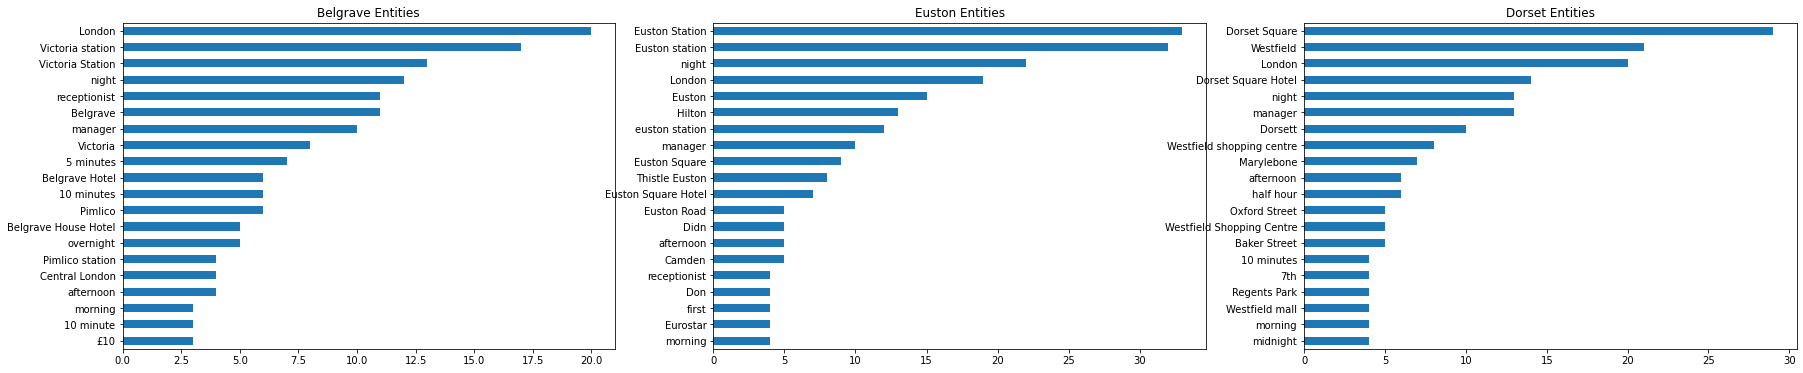

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))
entities_df[entities_df['Hotel Name'] == 'Belgrave']['ent_text'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[0], title='Belgrave Entities')
entities_df[entities_df['Hotel Name'] == 'Euston']['ent_text'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[1], title='Euston Entities') 
entities_df[entities_df['Hotel Name'] == 'Dorset']['ent_text'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[2], title='Dorset Entities') 

plt.show()

<span style="color:blue">We can also plot the the frequency of the various entity types for each hotel. We can see that the most importantly reviewed attributes of a hotel are related to the facility, location, and organization. These are areas that management can look to target in more detail to understand what can be improved.</span>

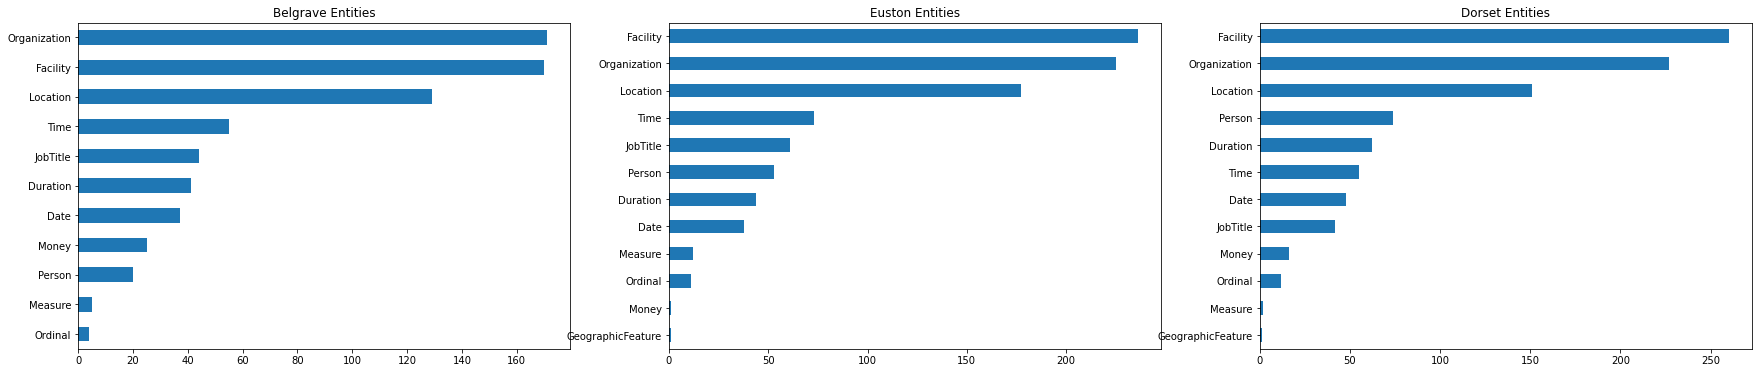

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))
entities_df[entities_df['Hotel Name'] == 'Belgrave']['ent_type'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[0], title='Belgrave Entities')
entities_df[entities_df['Hotel Name'] == 'Euston']['ent_type'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[1], title='Euston Entities') 
entities_df[entities_df['Hotel Name'] == 'Dorset']['ent_type'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[2], title='Dorset Entities') 

plt.show()

<span style="color:blue">Additionally the following code can be used to examine the review texts for a particular entity type at a specific hotel.</span>

In [21]:
# Entities for Belgrave Hotel where the entity type is Facility
entities_df[(entities_df['Hotel Name'] == 'Belgrave') & (entities_df['ent_type'] == 'Facility')]['ent_text']

1             Victorias station Pimlico line Good soundproof rooms
10     walk tube station Decent 20mins walk Buckingham palace Nice
15                                      Pimlico station tv English
24                                           Pimlico station hotel
25                                           Pimlico Victoria Tube
                                  ...                             
658                                             London.Worst hotel
659                          there.Though mentionned website hotel
666                               station bus station tube station
693                                           Belgrave House Hotel
696               Hotel iswithin walking distance victoria station
Name: ent_text, Length: 170, dtype: object

In [22]:
def create_word_cloud(top_level_cat_df, text):
    figure, ax1 = plt.subplots(ncols=1, figsize=(10,6))
    wc = WordCloud(width=600, height=400, background_color ='white').generate_from_frequencies(top_level_cat_df.value_counts().head(20))
    ax1.imshow(wc, interpolation="bilinear")
    ax1.axis('off')
    ax1.title.set_text(text)
    plt.show()
    
def create_word_cloud_list(df_list, text, name_list):
    figure, ax1 = plt.subplots(ncols=len(df_list), figsize=(10*len(df_list),6))
    for i in range(0, len(df_list)):
        wc = WordCloud(width=600, height=400, background_color ='white').generate_from_frequencies(df_list[i].value_counts().head(20))
        ax1[i].imshow(wc, interpolation="bilinear")
        ax1[i].axis('off')
        ax1[i].title.set_text(name_list[i] + ' ' + text)
    plt.show()

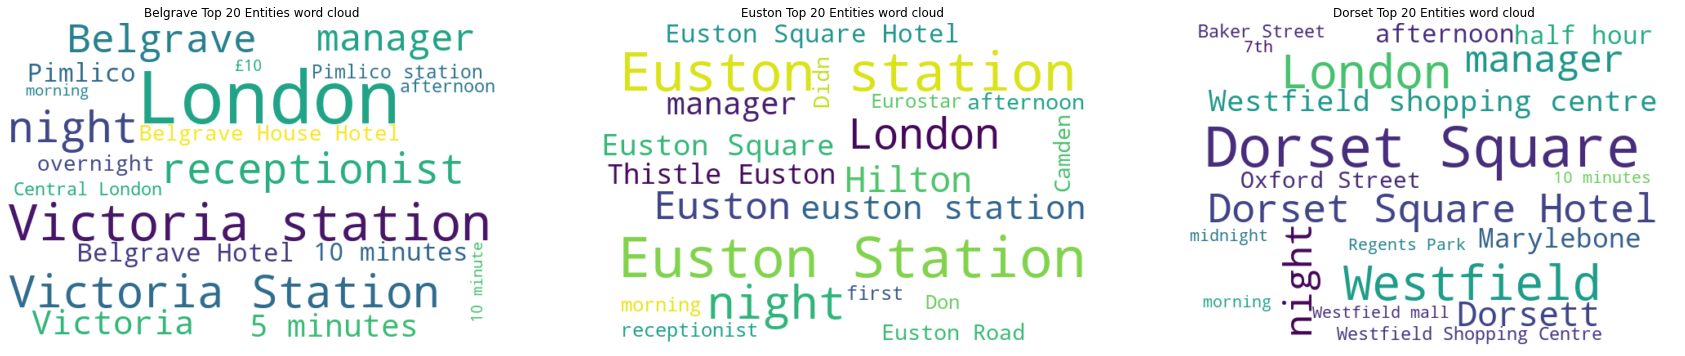

In [23]:
df_list = [entities_df[entities_df['Hotel Name'] == 'Belgrave']['ent_text'], 
           entities_df[entities_df['Hotel Name'] == 'Euston']['ent_text'], 
           entities_df[entities_df['Hotel Name'] == 'Dorset']['ent_text']]
name_list = ['Belgrave', 'Euston', 'Dorset']
create_word_cloud_list(df_list, "Top 20 Entities word cloud", name_list)

<span style="color:blue">To better display the list of entities that we can use as tags for each hotel, we can plot word clouds.</span>

<a id="website"></a>
### 3d. Comparison between Booking.com vs TripAdvisor for one hotel

Another approach to analyzing hotel customer reviews is by comparing the entity mentions found on the two websites where the reviews are published. Here we are looking at Booking.com vs TripAdvisor. We can hope to gain insight on the tendencies of reviewers who use one platform compared to the other platform.

<span style="color:blue">Let's plot side-by-side word clouds for each of the hotels.</span>

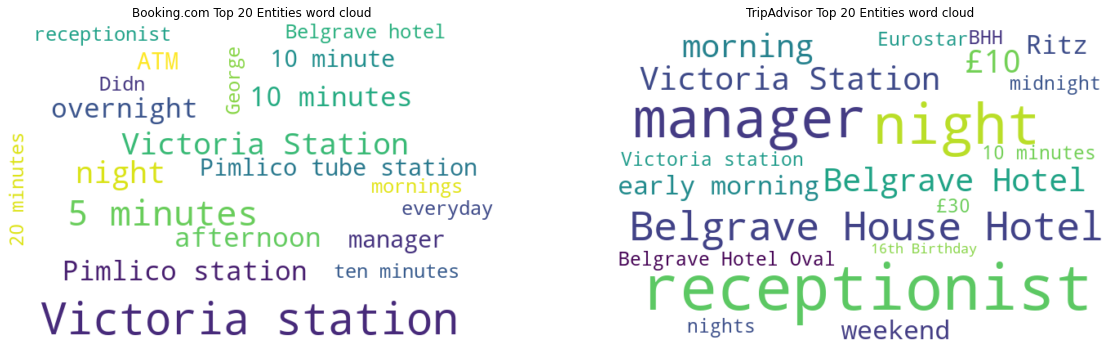

In [24]:
df_list = [entities_df[(entities_df['Hotel Name'] == 'Belgrave') & (entities_df['Website'] == 'Booking.com') & (entities_df['ent_type'] != 'Location')]['ent_text'], 
           entities_df[(entities_df['Hotel Name'] == 'Belgrave') & (entities_df['Website'] == 'TripAdvisor') & (entities_df['ent_type'] != 'Location')]['ent_text']]
name_list = ['Booking.com', 'TripAdvisor']
create_word_cloud_list(df_list, "Top 20 Entities word cloud", name_list)

Looks like customers on Booking.com care more about the convenience to tube stations where as TripAdvisor customers care more about the reception and atmosphere of the hotel itself.

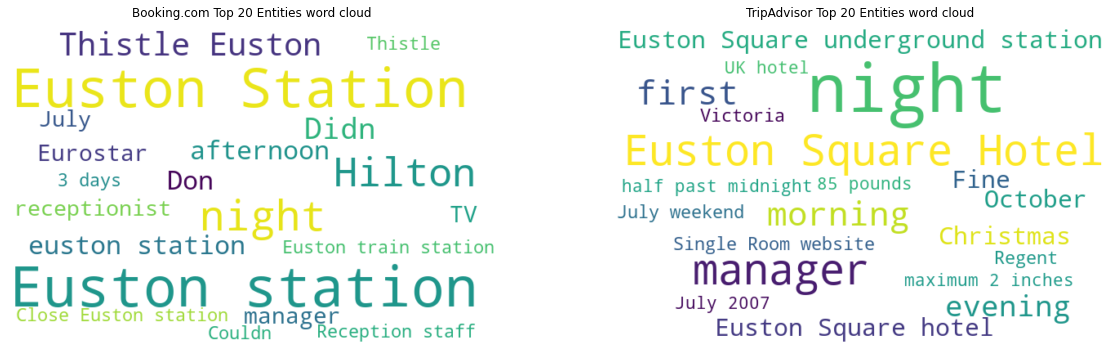

In [25]:
df_list = [entities_df[(entities_df['Hotel Name'] == 'Euston') & (entities_df['Website'] == 'Booking.com') & (entities_df['ent_type'] != 'Location')]['ent_text'], 
           entities_df[(entities_df['Hotel Name'] == 'Euston') & (entities_df['Website'] == 'TripAdvisor') & (entities_df['ent_type'] != 'Location')]['ent_text']]
name_list = ['Booking.com', 'TripAdvisor']
create_word_cloud_list(df_list, "Top 20 Entities word cloud", name_list)

Once again, we can see that customers on Booking.com care more about the convenience to tube stations where as TripAdvisor customers care more about the reception and atmosphere of the hotel itself.

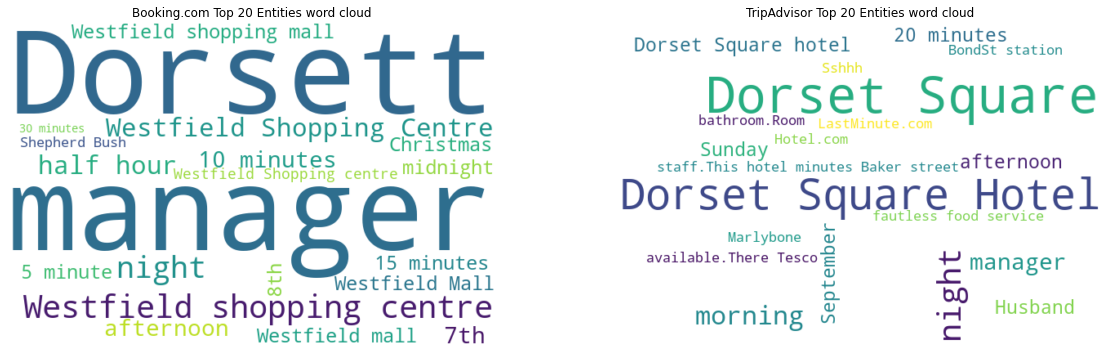

In [26]:
df_list = [entities_df[(entities_df['Hotel Name'] == 'Dorset') & (entities_df['Website'] == 'Booking.com') & (entities_df['ent_type'] != 'Location')]['ent_text'], 
           entities_df[(entities_df['Hotel Name'] == 'Dorset') & (entities_df['Website'] == 'TripAdvisor') & (entities_df['ent_type'] != 'Location')]['ent_text']]
name_list = ['Booking.com', 'TripAdvisor']
create_word_cloud_list(df_list, "Top 20 Entities word cloud", name_list)

**We can use this collective information to give priority to the website with reviews that better align with our own preferences about choosing a hotel. Do we care more about the convenience of the location of a hotel or do we care about the hotel's ambience, reception, perks?**

<a id="keyword"></a>
## 4. Keyword phrase extraction

Another Watson NLP capability we can utilize to analyze the hotel reviews is Keyword phrase extraction. The `keywords` block ranks noun phrases extracted from an input document based on how relevant they are within the document.

We will be using the `text-rank` model here. The text-rank model takes the output of Noun Phrase models and assigns a relevance score for each extracted noun phrase. The relevance score calculation is inspired by the Page Rank algorithm. In the context of the input document, extracted noun phrases that appear in “more connected” contexts receive a higher rank. In addition, the relevance score of extracted noun phrases is upgraded when the noun phrase appears more frequently in Wikipedia.

The Noun Phrases block extracts non-overlapping noun phrases from the input text. `noun-phrases_rbr` is implemented in AQL, the standard rule language in Watson NLP. The underlying implementation uses Izumo, the standard NLP primitives component in Watson NLP for tokenization, lemmatization and parts of speech, followed by the application of noun phrase chunking rules that are specific to each language.

In [27]:
# Keyword Extraction
# Load Noun Phrases, Embedding and Keywords models for English
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))
noun_phrases_model = watson_nlp.load(watson_nlp.download('noun-phrases_rbr_en_stock'))
keywords_model = watson_nlp.load(watson_nlp.download('keywords_text-rank_en_stock'))

In [28]:
pos_filter = {
    4,      # POS_AUX
    10,     # POS_PART
    11,     # POS_PRON
    15,     # POS_SYM
    17      # POS_X
}

def custom_tokenizer(text):
    # parse the text for pos tagging and lemmatization
    result = syntax_model.run(text, parsers=('lemma', 'part_of_speech'))

    # collect the terms that qualify as meaningful.
    # to qualify, a term must meet all conditions:
    # (a) not be pos-tagged as symbol / content-less word
    # (b) not be a stop-word from the pre-defined list
    # (c) be longer than 1 character
    terms = []
    for token in result.tokens:
        pos_tag = token.part_of_speech
        if pos_tag not in pos_filter:
            lemma = token.lemma.strip()
            text = token.span.text.strip()
            term = lemma if len(lemma) > 0 else text
            if len(term) >1:
                terms.append(term)
    return " ".join(terms)

This Keyword model depends on the Syntax and Noun Phrases blocks. 

<span style="color:blue">The following function captures the flow for running a keyword extraction model. First, we run the input document/text through the syntax model and the noun phrases model to extract noun texts. Then, we use both syntax output and noun output as inputs for the keyword model where the ouput will include the text phrase and relevance score. We can use this score to rank the phrases.</span>

In [29]:
def extract_keywords(text, hotel):
    # Run the Syntax and Noun Phrases models
    syntax_prediction = syntax_model.run(text, parsers=('token', 'lemma', 'part_of_speech'))
    noun_phrases = noun_phrases_model.run(text)
    # Run the keywords model
    keywords = keywords_model.run(syntax_prediction, noun_phrases, limit=5)  
    keywords_list = keywords.to_dict()['keywords']
    key_list = []
    for i in range(len(keywords_list)):
        dict_list = {}
        key = custom_tokenizer(keywords_list[i]['text'])
        dict_list['phrase'] = key
        dict_list['relevance'] = keywords_list[i]['relevance']
        key_list.append(dict_list)
    return {'Document':text,'Hotel Name':hotel,'Phrases':key_list}

<span style="color:blue">The following function creates a list from the the documents in the DataFrame for a specified hotel name. This list will be used as input in the for `extract_keywords()` function above.</span>

In [30]:
def top_doc_generator(hotel_name):
    top_doc_list =[]
    for index, row in analysis_df.iterrows():
        if row['Hotel Name'] == hotel_name:
            top_doc_list.append(row['Document'])
    return top_doc_list

<span style="color:blue">Create three separate lists for each of the hotels in the DataFrame.</span>

In [31]:
top_doc_euston = top_doc_generator('Euston')
top_doc_dorset = top_doc_generator('Dorset')
top_doc_belgrave = top_doc_generator('Belgrave')

<span style="color:blue">The following function runs `extract_keywords()` and then parses the result by exploding DataFrames until the `Phrases` column is fully parsed.</span>

In [32]:
def explode_phrases(top_doc_list, hotel):
    keywords = [extract_keywords(doc, hotel) for doc in top_doc_list] 
    phrases_df = pd.DataFrame(keywords)

    exp_phrases = phrases_df.explode('Phrases')
    exp_phrases = exp_phrases.dropna(subset=['Phrases'])
    exp_phrases = pd.concat([exp_phrases.drop(['Phrases'], axis=1), exp_phrases['Phrases'].apply(pd.Series)], axis=1)
    exp_phrases['phrase_length'] = exp_phrases['phrase'].apply(lambda x: len(x.split(' ')))
    # Removing uni-gram and bi-grams
    exp_phrases = exp_phrases[exp_phrases.phrase_length > 2]
    return exp_phrases

In [33]:
exp_phrases_euston = explode_phrases(top_doc_euston, 'Euston')
exp_phrases_dorset = explode_phrases(top_doc_dorset, 'Dorset')
exp_phrases_belgrave = explode_phrases(top_doc_belgrave, 'Belgrave')

<span style="color:blue">Examine one of the hotels. The extracted and parse data occupy the `phrase`, `relevance`, `phrase_length` columns.</span>

In [34]:
exp_phrases_euston.head()

Document  \
0  noisy property Workmen drilling renovations breakfast room sound made leave enjoy breakfast offerings loud hotel asked workmen begin work area breakfast service understand renovations undertaken care relation guest comfort disappointing listed booking website Hilton website renovations taking place bed comfortable room clean wifi strong staff members lovely welcoming location close Euston Stat...   
0  noisy property Workmen drilling renovations breakfast room sound made leave enjoy breakfast offerings loud hotel asked workmen begin work area breakfast service understand renovations undertaken care relation guest comfort disappointing listed booking website Hilton website renovations taking place bed comfortable room clean wifi strong staff members lovely welcoming location close Euston Stat...   
0  noisy property Workmen drilling renovations breakfast room sound made leave enjoy breakfast offerings loud hotel asked workmen begin work area breakfast service understand renovations undertaken care relation guest comfort disappointing listed booking website Hilton website renovations taking place bed comfortable room clean wifi strong staff members lovely welcoming location close Euston Stat...   
0  noisy property Workmen drilling renovations breakfast room sound made leave enjoy breakfast offerings loud hotel asked workmen begin work area breakfast service understand renovations undertaken care relation guest comfort disappointing listed booking website Hilton website renovations taking place bed comfortable room clean wifi strong staff members lovely welcoming location close Euston Stat...   
0  noisy property Workmen drilling renovations breakfast room sound made leave enjoy breakfast offerings loud hotel asked workmen begin work area breakfast service understand renovations undertaken care relation guest comfort disappointing listed booking website Hilton website renovations taking place bed comfortable room clean wifi strong staff members lovely welcoming location close Euston Stat...   

  Hotel Name                                  phrase  relevance  phrase_length  
0     Euston         renovation breakfast room sound   0.871282              4  
0     Euston                  noisy property workman   0.721332              3  
0     Euston  book website Hilton website renovation   0.657340              5  
0     Euston             work area breakfast service   0.594659              4  
0     Euston             care relation guest comfort   0.588937              4

<span style="color:blue">We can further understand the results of the keyword phrase extraction model by plotting the top 20 more relevant phrases for each hotel. Notice that the relevance score of the top 20 phrases is above 0.98, meaning that there are plenty more phrases with high relevance that aren't being shown here. </span>

In [35]:
import plotly.express as px
import math
lowest_rel = exp_phrases_belgrave.sort_values('relevance', ascending=True).tail(20).reset_index().drop(['index'], axis=1).head(1)['relevance'][0]
lower_bound = math.floor(lowest_rel*100)/100
fig = px.bar(exp_phrases_belgrave.sort_values('relevance', ascending=True).tail(20), x='relevance', y='phrase',orientation='h')
fig.update_xaxes(range=[lower_bound, 1.0])

(0.985, 1.0)

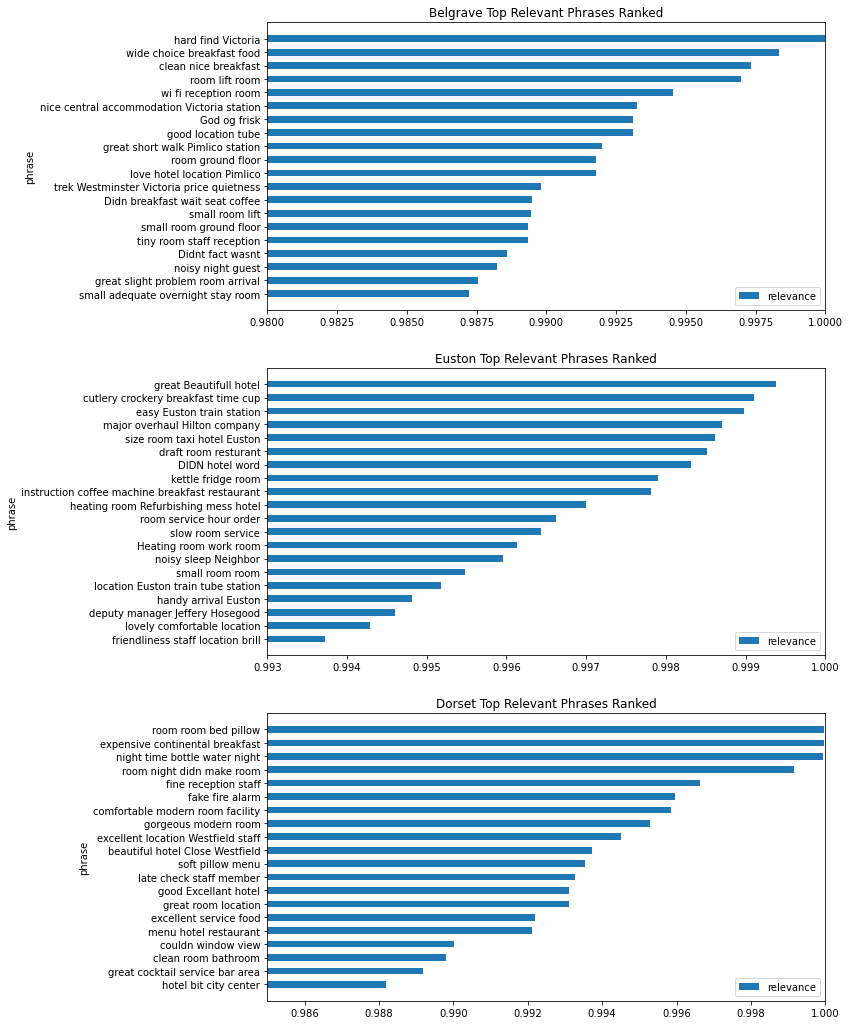

In [36]:
fig, ax2 = plt.subplots(nrows=3, figsize=(10,18))
exp_phrases_belgrave.sort_values('relevance', ascending=True).tail(20).plot.barh(x='phrase',y='relevance', title='Belgrave Top Relevant Phrases Ranked', ax=ax2[0])
ax2[0].autoscale()
ax2[0].set_xlim(0.98,1.0)
exp_phrases_euston.sort_values('relevance', ascending=True).tail(20).plot.barh(x='phrase',y='relevance', title='Euston Top Relevant Phrases Ranked', ax=ax2[1])
ax2[1].autoscale()
ax2[1].set_xlim(0.993,1.0)
exp_phrases_dorset.sort_values('relevance', ascending=True).tail(20).plot.barh(x='phrase',y='relevance', title='Dorset Top Relevant Phrases Ranked', ax=ax2[2])
ax2[2].autoscale()
ax2[2].set_xlim(0.985,1.0)

These top-ranked phrases can be used to generate a brief description of the most noteable attributes of each hotel. Customers can find interest in a particular hotel with just take one look at the list of phrases.

<a id="search"></a>
## 5. Entity and Phrase Search

One of the applications of entity detection is in searching. We can search for entitiy mentions and phrases by using them as tags of reviews in our large London hotel reviews dataset.

<span style="color:blue">Because for the size of the dataset, we will start by randomly sampling 5% of the dataset. (random_state = 1 for consistency within the results discussed in this notebook)</span>

In [37]:
hotels_df_sample = hotels_df.sample(frac = 0.05, random_state = 1)

In [38]:
hotels_extract_list = run_extraction([hotels_df_sample], 'text')

In [39]:
hotels_analysis_df = pd.DataFrame(columns=['Document','Hotel Name', 'Website', 'Entities'])
hotels_analysis_df = hotels_analysis_df.append(hotels_extract_list,ignore_index = True)
hotels_exp_entities = hotels_analysis_df.explode('Entities')
hotels_entities_df = pd.concat([hotels_exp_entities.drop('Entities', axis=1), hotels_exp_entities['Entities'].apply(pd.Series)], axis=1).reset_index().drop(['index'],axis=1)

In [40]:
def explode_phrases2(hotels_df):
    keywords = []
    for index, row in hotels_df.iterrows():
        keywords.append(extract_keywords(row['Document'], row['Hotel Name']))
    phrases_df = pd.DataFrame(keywords)

    exp_phrases = phrases_df.explode('Phrases')
    exp_phrases = exp_phrases.dropna(subset=['Phrases'])
    exp_phrases = pd.concat([exp_phrases.drop(['Phrases'], axis=1), exp_phrases['Phrases'].apply(pd.Series)], axis=1)
    exp_phrases['phrase_length'] = exp_phrases['phrase'].apply(lambda x: len(x.split(' ')))
    # Removing uni-gram and bi-grams
    exp_phrases = exp_phrases[exp_phrases.phrase_length > 2]
    return exp_phrases

Running the phrase extraction function will take some time.

In [41]:
exp_phrases_hotels = explode_phrases2(hotels_analysis_df)

<span style="color:blue">With the results of the entity extraction and keyword phrase detection, we can merge the two dataframes and then reduce the rows to compress the dataframe into one unique review per row.</span>

In [42]:
hotels_entities_phrases = pd.merge(hotels_entities_df, exp_phrases_hotels, on=['Document', 'Hotel Name']).drop_duplicates()
combined_phrases_df = hotels_entities_phrases.groupby(['Document','Hotel Name', 'ent_text'])['phrase'].apply(lambda x: '; '.join(x)).reset_index()
compressed_hotels = combined_phrases_df.groupby(['Document','Hotel Name','phrase'])['ent_text'].apply(lambda x: '; '.join(x)).reset_index()

In [43]:
compressed_hotels.sample(n=5)

Document  \
1950                                                                                                                                                                                                                                                                                                                                                 Staff helpful courteous Fantastic location road Trafalgar Square   
1849                                                                                                                                                                                                                                                                                                                                                Showers powerful Clean hotel friendly staff Minutes train station   
1775                                                                                                                                                                                                  Rooms extremely small room move floor mat shower pressure shower bathroom dated location bar communal areas excellent breakfast rooms big Premier inn locally half price size quality actual room expect Hilton   
67    4 adults staying hotel, advantage 3-night stay unbeatable 48 GBP night.Hotel easy find, 30 meters corner tube station Aldgate East, convenient. Taxi Oxford Street cost 16 GBP night. Nice welcoming staff, internet lobby free newspapers.Rooms clean space. Bathroom spotless. TV internet available. Breakfast however, chaotic. stayed Easter hotel fully booked. Loooong waiting line run people served...   
5578  stayed 4 nights October '06, reading good reviews hotel.Basically, high expecations - met.Positives:-Cool contemporary designs/decor-Close location North Acton Station-Friendly bar staff-Good breakfastsNegatives:-Undergound commutes hotel eat LOT time.-Lack service [no baggage assistance/room service etc.]-Many staff members pompous rude [I felt unwelcomed staff members... greeted check-in]Ove...   

                                Hotel Name  \
1950  Club Quarters Hotel Trafalgar Square   
1849       Best Western PLUS Epping Forest   
1775  DoubleTree by Hilton London West End   
67                        Ibis London City   
5578             Ramada Encore London West   

                                                                     phrase  \
1950             helpful courteous fantastic location road Trafalgar Square   
1849              powerful clean hotel; friendly staff minute train station   
1775                      excellent breakfast room; half price size quality   
67    nice welcoming staff; small grocery store; nice remove breakfast bill   
5578               Undergound commute hotel; high expecations met.Positives   

                                                                                                                            ent_text  
1950                                                                                                                Trafalgar Square  
1849                                                                                                                     Clean hotel  
1775                                                                                         Hilton; breakfast rooms big Premier inn  
67                           30 meters; Aldgate East; Easter hotel; Loooong; Nearby nice traditional english pub; Taxi Oxford Street  
5578  London; North Acton Station-Friendly bar staff-Good breakfastsNegatives:-Undergound commutes hotel; October '06; Ramada Encore

<span style="color:blue">The following is a function built to take a list of mentions as the input. The function will return the dataframe rows that have those exact mentions.</span>

In [44]:
def search_entity(hotels_df, entities_list, phrases_list):
    search_df = hotels_df[(hotels_df['ent_text'].str.lower().str.contains('|'.join(entities_list).lower())) & 
                          (hotels_df['phrase'].str.lower().str.contains('|'.join(phrases_list).lower()))]
    hotel_count = search_df['Hotel Name'].value_counts().to_dict()
    return search_df, hotel_count

<span style="color:blue">For example, if we care about the food, cleanliness, and convenience of a hotel; we can use the words `good breakfast`, `room service`, `clean`, and `shopping` to look for hotel reviews that mention these entities and phrases. We hope to find a shortend list of hotels that fulfill our criteria.</span>

In [45]:
search_entities = ['clean', 'shopping']
search_phrases = ['good breakfast', 'room service']
search_df, hotel_count = search_entity(compressed_hotels, search_entities, search_phrases)

<span style="color:blue">The search returned 5 hotels that mention `good breakfast`, `room service`, `clean`, and `shopping`.</span>

In [46]:
hotel_count

{'Grange City Hotel': 1,
 'The Cumberland A Guoman Hotel': 1,
 ' The Rembrandt': 1,
 'Royal Garden Hotel': 1,
 ' Hilton London Kensington': 1}

<span style="color:blue">Just based on the results of the entity and phrase extraction search, we can determine that these 5 hotels best offer the features that we are looking for. To get a better idea of how the hotels were received, we can read all of the reviews from each of the hotels that matched.</span>

In [47]:
search_df.groupby('Hotel Name').first()

Document  \
Hotel Name                                                                                                                                                                                                                                                                                                                                                                                                                                       
 Hilton London Kensington      wife overnight show stayed Kensington Hilton. convenient Oxford Tube (bus) stopped collected day. Initially apprehensive hotel 1970s monstrosity, however, entering pleasantly surprised. spacious, clean welcoming hotel excellent staff (especially Rashid concierge helped bus routes directions etc). room executive room (6035) nice small tea/coffee making facilities, flatscreen TV freeview, safe, ...   
 The Rembrandt                                                     Road Victoria Albert Museum, close South Kensington Museums Knightsbridge shopping, hotel 5 minutes walk west South Kensington underground station 20-30 minutes centre City. Rooms comfortable air conditioned, bathrooms tiny. Rooms back quiet. good breakfast buffet offered. dinner, close range restaurants South Kensington, - east - Knightsbridge. pricey, hotels.   
Grange City Hotel                                                                                                                                                                                                                                        Breakfast prices high Beautiful hotel perfect location Luxurious comfortable Spotlessly clean Nice leisure facilities Professional accommodating service Room service good real treat   
Royal Garden Hotel                                                                                                                                                                                                                                                                                                                                                          thing location view cleaness room service friendly stuff size room   
The Cumberland A Guoman Hotel                                                                                                           Cleaning Room service restaurant helpful answer telephone called restaurant serve hot food gas happen hotel cumberland cumberland feel home Fernando helpful hotel managers daughters conceirge especiall martin jack hard workers helpful smile eve reception found rooms maintinance staff make easy   

                                                                                                                                                               phrase  \
Hotel Name                                                                                                                                                              
 Hilton London Kensington                                                                      room executive room; comment room service menu; flatscreen TV freeview   
 The Rembrandt                 Road Victoria Albert Museum; west South Kensington underground station; close range restaurant South Kensington; good breakfast buffet   
Grange City Hotel                                                  high beautiful hotel; clean nice leisure facility; professional accommodating service room service   
Royal Garden Hotel                                                                                friendly stuff size room; thing location view cleaness room service   
The Cumberland A Guoman Hotel                                   helpful answer telephone; cleaning room service restaurant; hotel cumberland cumberland; hot food gas   

                                                                                                                                                                                                ent_tex

<a id="targetSentiment"></a>
## 6. Actionable insights using entities and keyword phrase extraction combined with sentiment analysis

For these 5 hotels, we can determine the targeted sentiment for the phrases found in their reviews. We want to make sure that the entities and phrases we've detected are positive so that we can make an accurate decision on which hotel to pick.

The Targets Sentiment Extraction block contains algorithms for the task of extracting the sentiments expressed in text and identifying the targets of those sentiments. The block automatically outputs both the target terms and the sentiment expressed towards each target term when given an input text.

For example, given the input:

    “The served food was delicious, yet the service was slow.”

The block identifies that there is a positive sentiment expressed towards the target “food”, and a negative sentiment expressed towards “service”. A significant advantage of this block is that it can handle multiple targets with different sentiments in one sentence. For the above example, it automatically identifies the positive sentiment towards “food” and the negative sentiment towards “service”.

In [48]:
sentiment_extraction_model = watson_nlp.load(watson_nlp.download('targets-sentiment_sequence-bert_multi_stock'))

This Target Sentiment Extraction model depends on the Syntax block. 

<span style="color:blue">The following function captures the flow for running a target sentiment extraction model. First, we run the input document/text through the syntax model. Then, we use the syntax output as input for the target sentiment extraction model where the ouput will include the target text and their sentiment. We will return the outputs into two separate lists of positive and negative sentiment text as well as one list of labels for every phrase.</span>

In [49]:
def run_sentiment(df, text_col, ent_col):
    pos_targets =[]
    neg_targets =[]
    targets = []
    entities = dict(df[ent_col])
    for text, hotel in zip(df[text_col], df['Hotel Name']):
        syntax_analysis_en = syntax_model.run(text, parsers=('token',))
        extracted_sentiments = sentiment_extraction_model.run(syntax_analysis_en)
        for key , score in extracted_sentiments.to_dict()['targeted_sentiments'].items():
            label = score['label']
            targets.append({'Hotel Name' : hotel, 'phrase' : key, 'sentiment' : score['label']})
            if label=='SENT_POSITIVE': # and key not in pos_targets:
                pos_targets.append(key)
            elif label=='SENT_NEGATIVE': # and key not in neg_targets:
                neg_targets.append(key)
    return pos_targets, neg_targets, targets

In [50]:
pos_targets_search, neg_targets_search, targets_search = run_sentiment(search_df, 'Document', 'phrase')
targets_df = pd.DataFrame(targets_search)

<span style="color:blue">We can display a word cloud for the positive sentiment phrases of every hotel in the search result to get a better view at the well rated features of each hotel. </span>

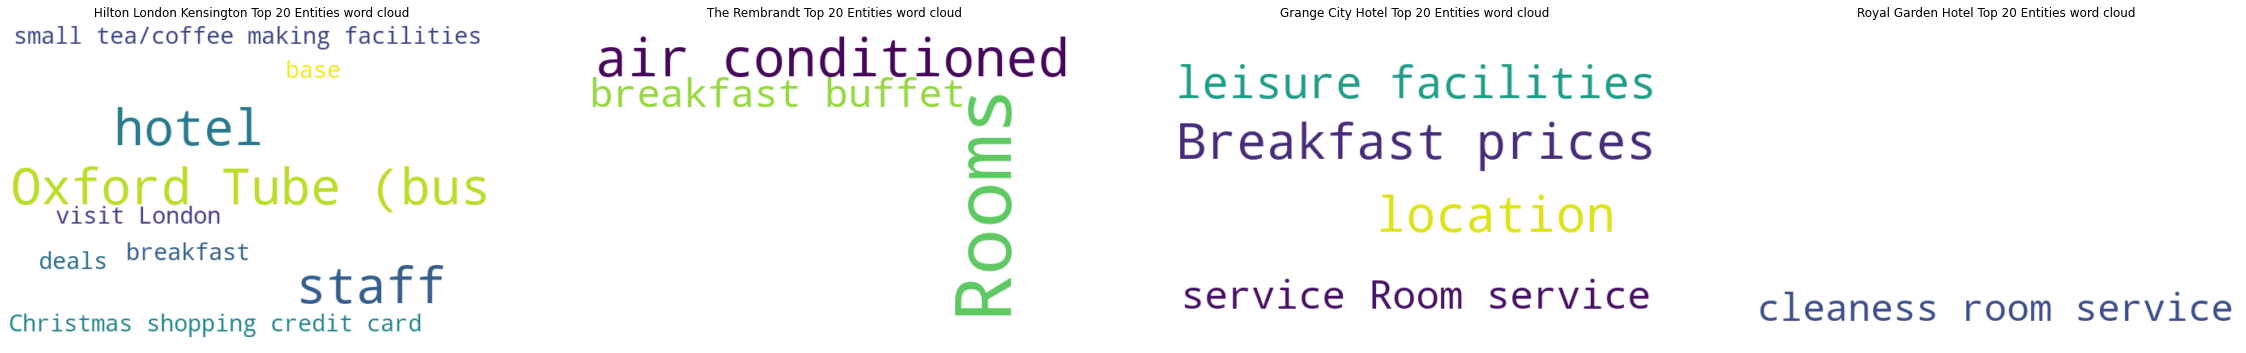

In [51]:
df_list = [g for _,g in targets_df.groupby('Hotel Name')]
df_phrase_list = [col[col['sentiment']=='SENT_POSITIVE']['phrase'] for col in df_list]
name_list = [col['Hotel Name'].unique()[0] for col in df_list]
create_word_cloud_list(df_phrase_list, "Top 20 Entities word cloud", name_list)

In [52]:
targets_df[targets_df['phrase'].str.contains('|'.join(search_phrases))]

Hotel Name                 phrase      sentiment
8  Royal Garden Hotel  cleaness room service  SENT_POSITIVE

In [53]:
targets_df.sample(frac=0.1)

Hotel Name            phrase      sentiment
6               The Rembrandt  breakfast buffet  SENT_POSITIVE
16   Hilton London Kensington             deals  SENT_POSITIVE

<span style="color:blue">To better display the list of positive entities and negative entities, we can plot word clouds.</span>

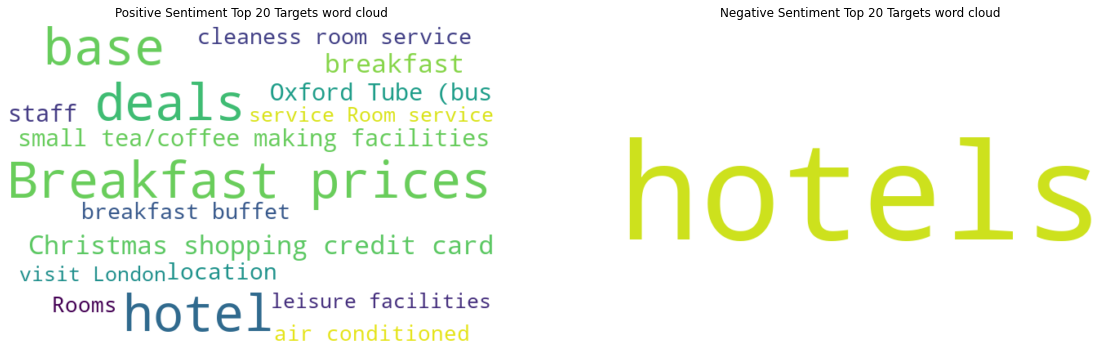

In [54]:
create_word_cloud_list([pd.DataFrame(pos_targets_search)[0], pd.DataFrame(neg_targets_search)[0]], 
                       "Sentiment Top 20 Targets word cloud", 
                       ['Positive', 'Negative'])

By examining the positive and negative entity sentiment list, we can quickly determine which aspect of the hotel need improvement and which aspects the hotel excels at.

## 6. Summary

This notebook shows you how to use the Watson NLP library and how easily you can run various entity, phrase, and target sentiment extraction models on input text. This notebook also demonstrated one possible application of Watson NLP.

Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the [GitHub](https://github.com/ibm-build-lab/Watson-NLP).

Developed by IBM Build Lab

Copyright - 2022 IBM Corporation